<a href="https://colab.research.google.com/github/iamrosan/Fake-News-Detection-BCT-Mini-Project-/blob/lstm-keras/lstmModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import pandas as pd
import numpy as np

#Visualization libraries
import matplotlib.pyplot as plt 
from matplotlib import rcParams
import seaborn as sns
from textblob import TextBlob
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import iplot
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

#NLTK libraries
import nltk
import re
import string
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
 

#Metrics libraries
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
from keras.preprocessing import text,sequence

from sklearn.model_selection import train_test_split

#Miscellanous libraries
from collections import Counter

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_true = pd.read_csv('/content/drive/MyDrive/ProcessedData/processedTrue.csv')
df_fake = pd.read_csv('/content/drive/MyDrive/ProcessedData/processedFake.csv')

In [4]:
df = pd.concat([df_true, df_fake])

In [5]:
df.head()

,Unnamed: 0,label,content
0,0,0,u budget fight loom republicans flip fiscal sc...
1,1,0,u military accept transgender recruit monday p...
2,2,0,senior u republican senator let mr mueller job...
3,3,0,fbi russia probe help australian diplomat tip ...
4,4,0,trump want postal service charge much amazon s...


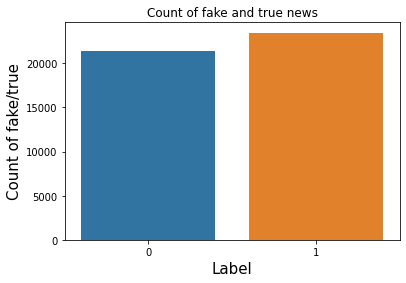

In [6]:
ax=sns.countplot(x="label", data=df)

#Setting labels and font size
ax.set(xlabel='Label', ylabel='Count of fake/true',title='Count of fake and true news')
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(15)

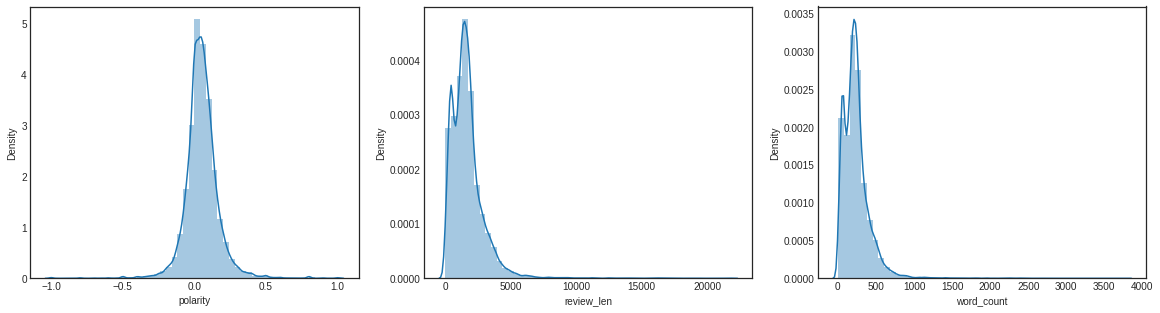

In [7]:
#Extracting the features from the news
df['polarity'] = df['content'].map(lambda text: TextBlob(text).sentiment.polarity)
df['review_len'] = df['content'].astype(str).apply(len)
df['word_count'] = df['content'].apply(lambda x: len(str(x).split()))

#Plotting the distribution of the extracted feature
plt.figure(figsize = (20, 5))
plt.style.use('seaborn-white')
plt.subplot(131)
sns.distplot(df['polarity'])
fig = plt.gcf()
plt.subplot(132)
sns.distplot(df['review_len'])
fig = plt.gcf()
plt.subplot(133)
sns.distplot(df['word_count'])
fig = plt.gcf()

In [9]:
#Function to get top n words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#Calling function and return only top 20 words
common_words = get_top_n_words(df['content'], 20)

#Printing the word and frequency
for word, freq in common_words:
    print(word, freq)

# #Creating the dataframe of word and frequency
# df1 = pd.DataFrame(common_words, columns = ['content' , 'count'])

# #Group by words and plot the sum
# df1.groupby('content').sum()['count'].sort_values(ascending=False).iplot(
#     kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in content')

say 173885
trump 148730
state 64214
president 57363
would 55437
people 42453
make 40421
one 38319
go 34672
new 32814
take 32257
house 31659
obama 31346
tell 31092
also 31065
clinton 30200
time 29806
reuters 29554
donald 28952
get 28646


In [10]:
#Function to get top bigram words
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#Calling function and return only top 20 words
common_words = get_top_n_bigram(df['content'], 20)

#Printing the word and frequency
for word, freq in common_words:
    print(word, freq)
    
# #Creating the dataframe of word and frequency
# df3 = pd.DataFrame(common_words, columns = ['content' , 'count'])

# #Group by words and plot the sum
# df3.groupby('content').sum()['count'].sort_values(ascending=False).iplot(
#     kind='bar', yTitle='Count', linecolor='black', title='Top 20 bigrams in content')

donald trump 27247
unite state 18827
white house 16248
hillary clinton 10114
new york 9245
feature image 7779
north korea 7367
president donald 6992
washington reuters 6678
twitter com 6565
image via 6344
trump say 6265
pic twitter 6146
barack obama 5769
year old 5096
president trump 5094
prime minister 4862
last week 4751
last year 4751
supreme court 4681


In [11]:
#Function to get top trigram words
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#Calling function and return only top 20 words
common_words = get_top_n_trigram(df['content'], 20)

#Printing word and their respective frequencies
for word, freq in common_words:
    print(word, freq)

president donald trump 6930
pic twitter com 6146
president barack obama 3901
new york time 2143
donald trump realdonaldtrump 1790
reuters president donald 1565
black live matter 1535
washington reuters president 1533
white house say 1237
president unite state 1195
elect donald trump 1177
president elect donald 1115
new york city 1051
president vladimir putin 977
news century wire 941
donald trump say 940
national security adviser 921
affordable care act 907
director jam comey 883
respond request comment 882


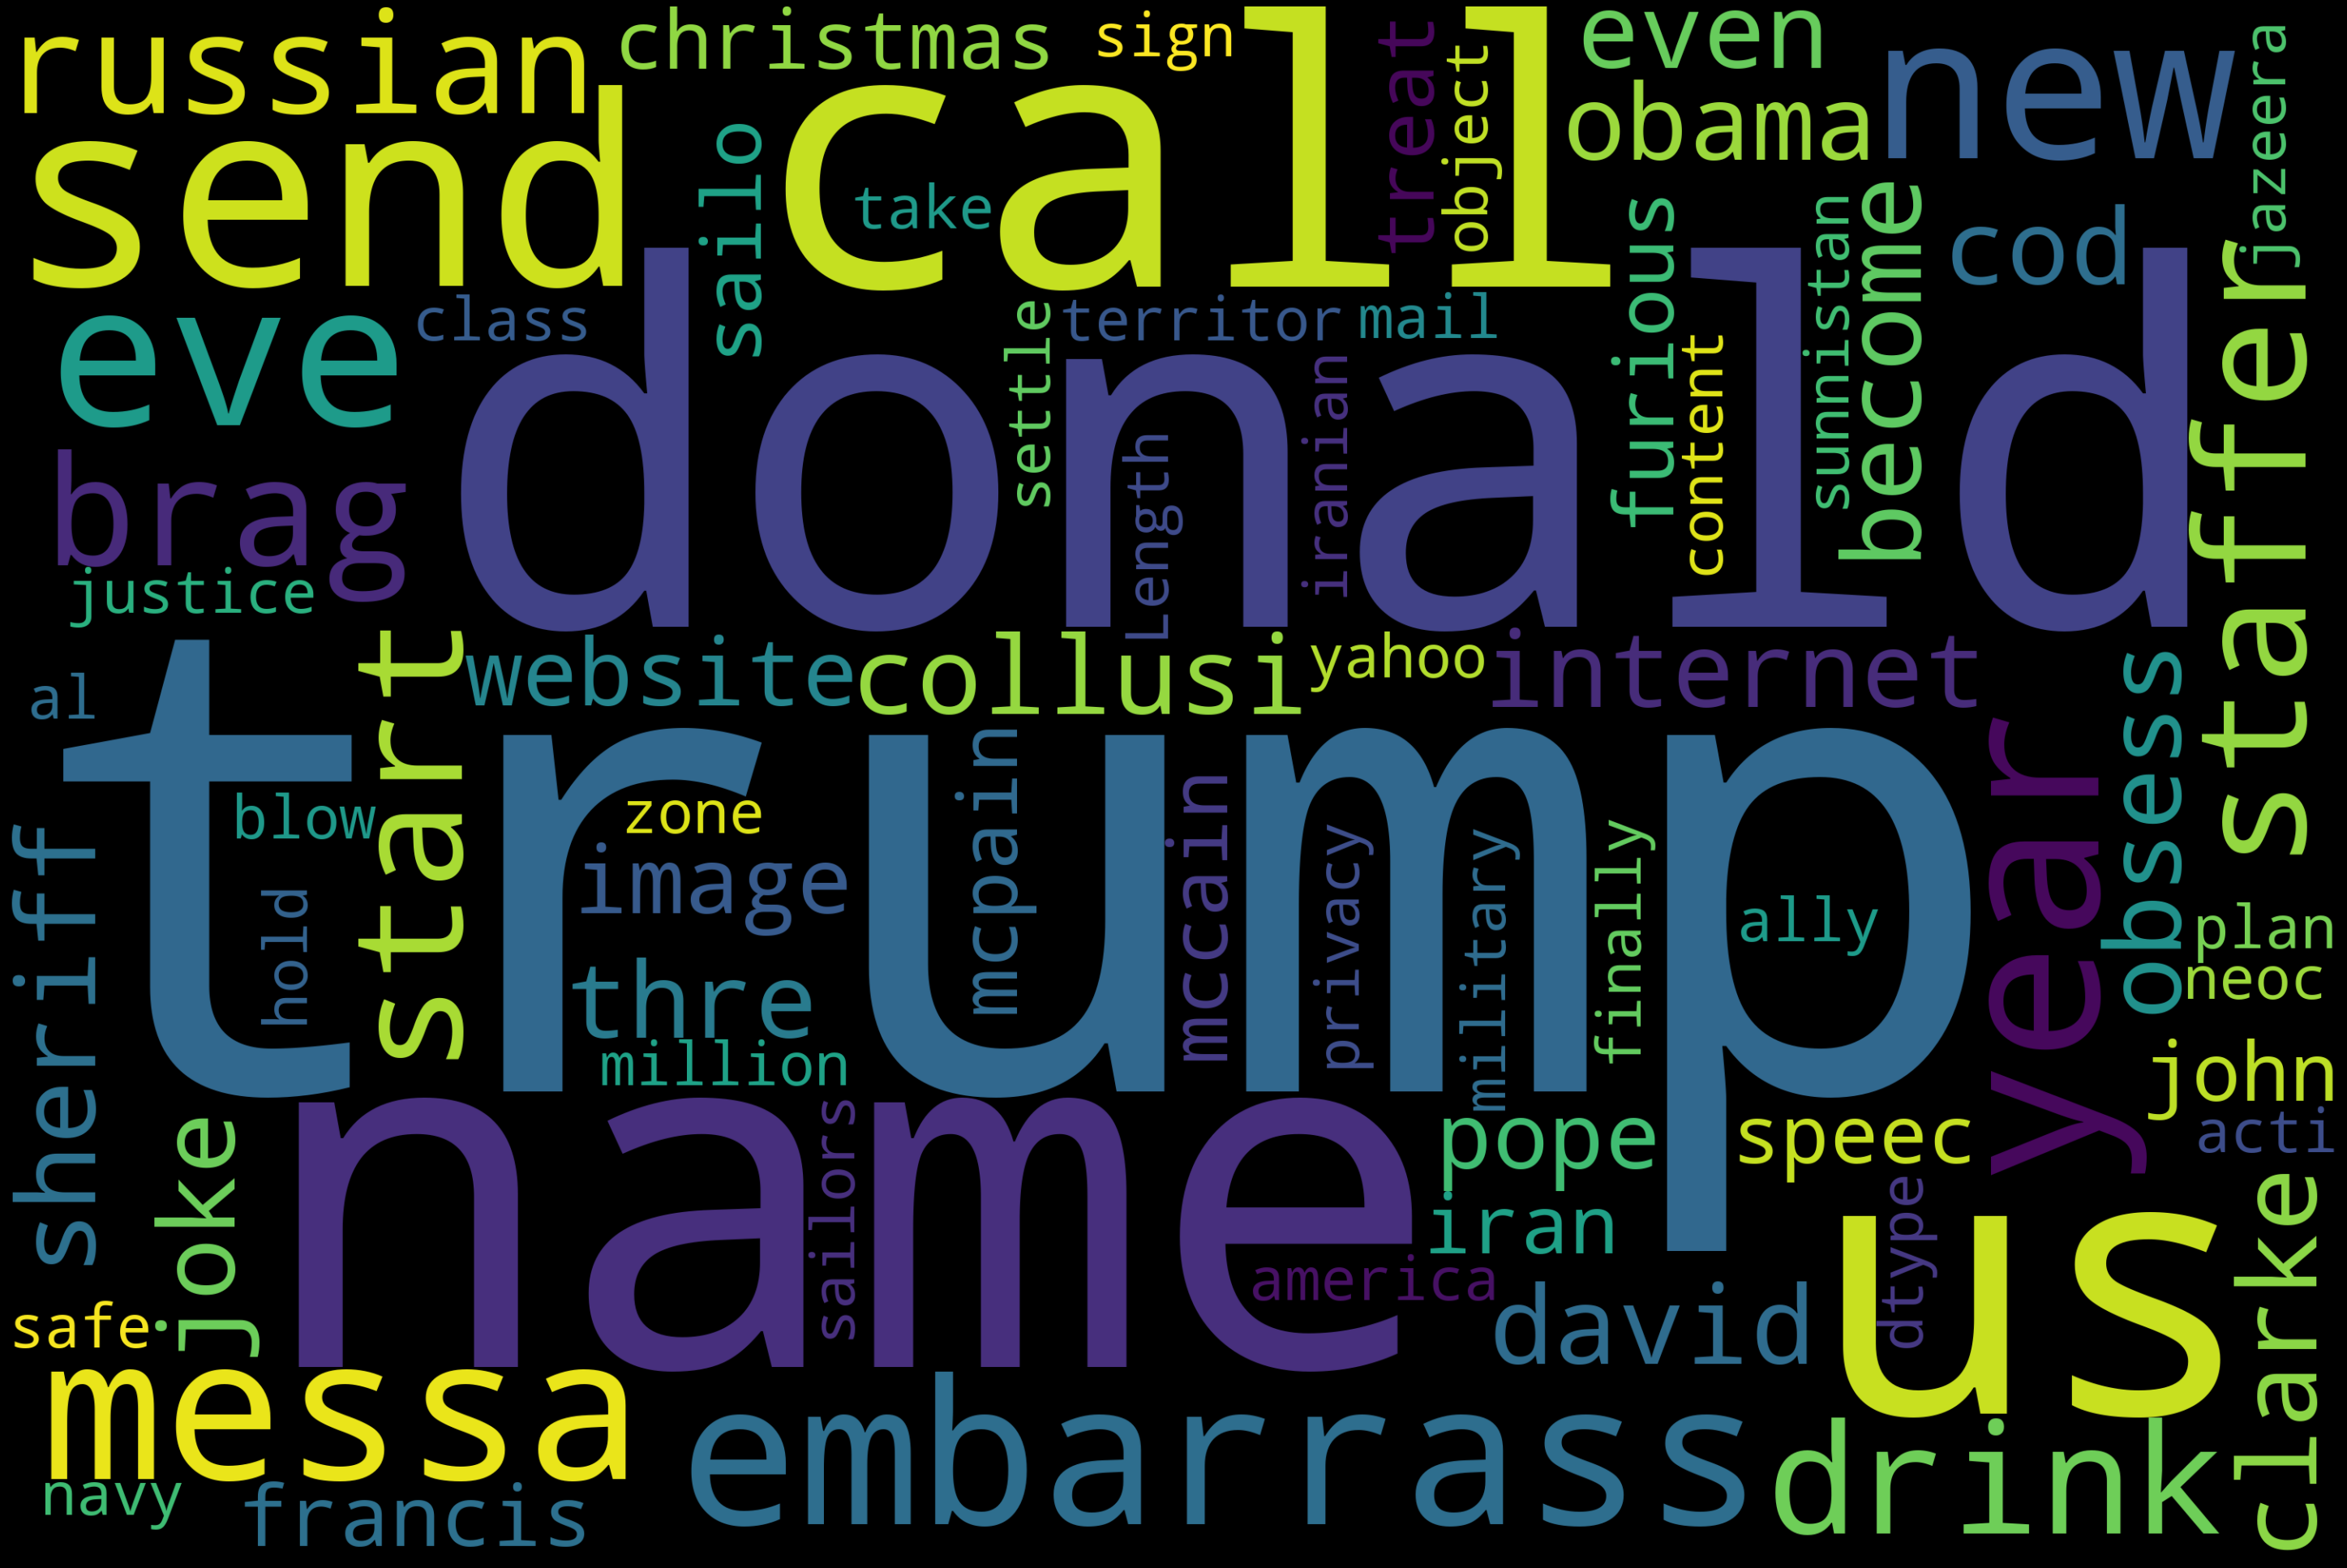

In [12]:
text = df_fake["content"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

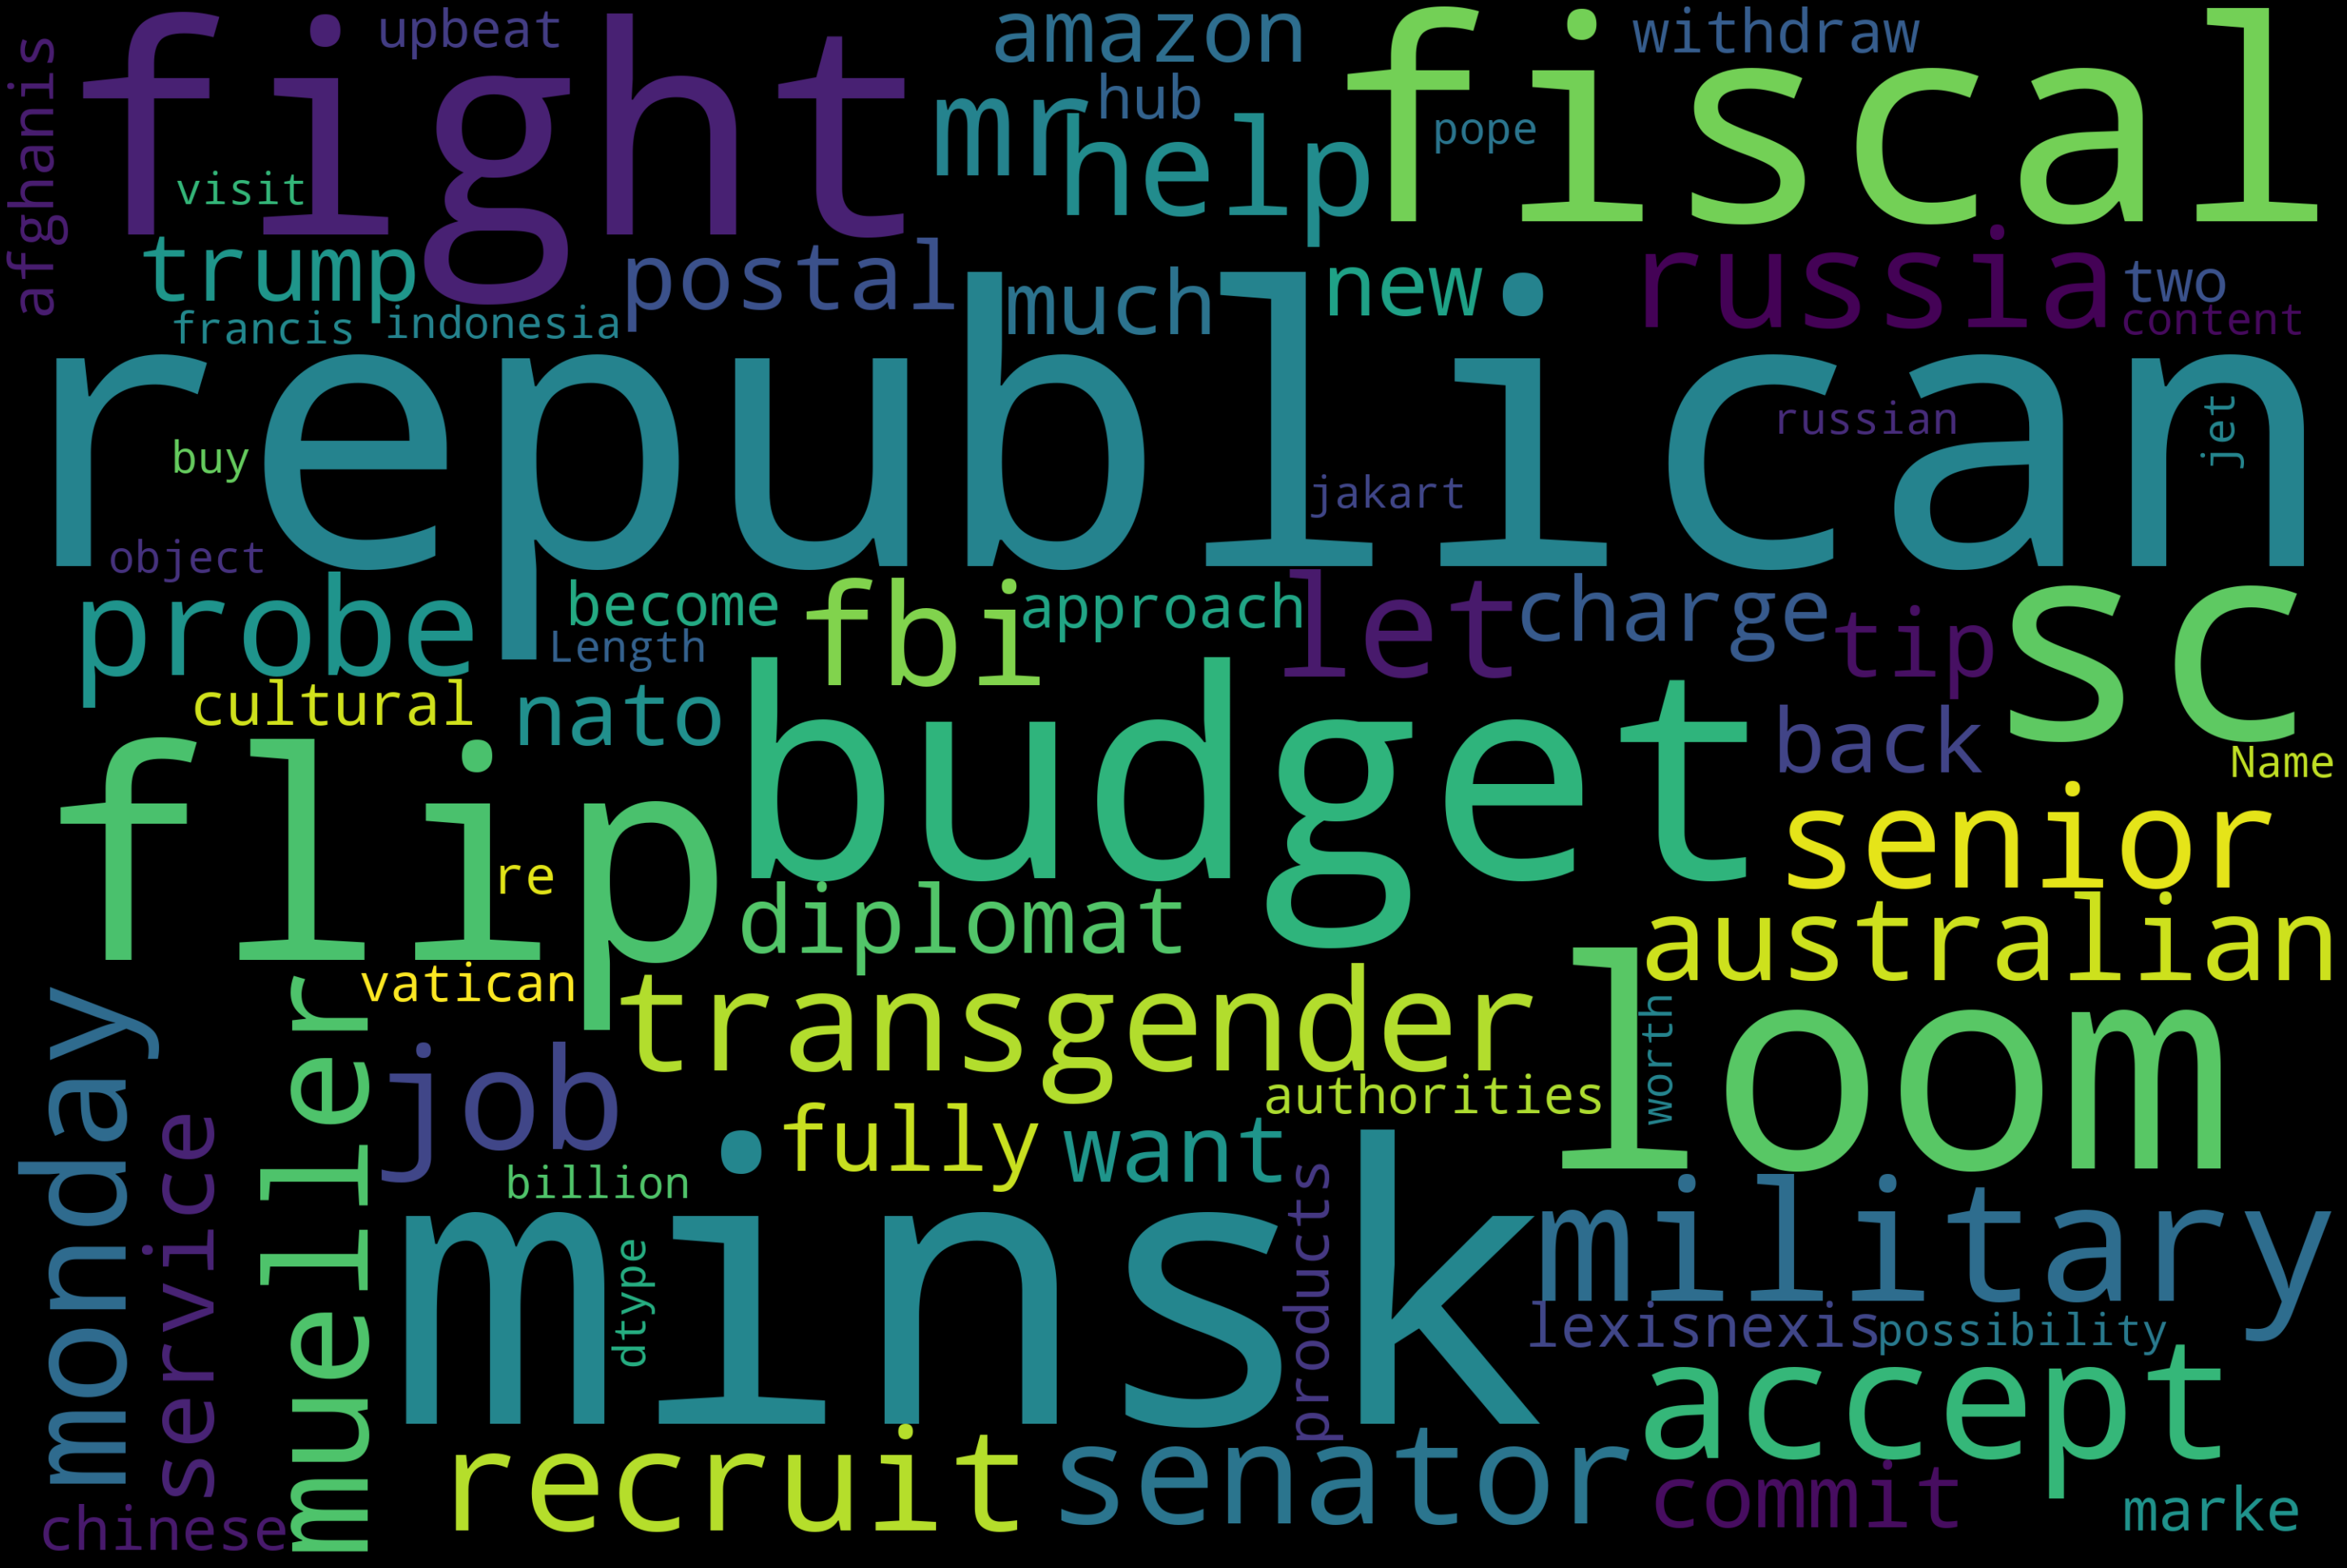

In [13]:
text = df_true["content"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [22]:
X = df['content']
y = df.label

In [23]:
X.head()

0    u budget fight loom republicans flip fiscal sc...
1    u military accept transgender recruit monday p...
2    senior u republican senator let mr mueller job...
3    fbi russia probe help australian diplomat tip ...
4    trump want postal service charge much amazon s...
Name: content, dtype: object

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.2,
                                                    random_state=42)

In [25]:
max_features = 10000
max_len = 300
batch_size = 256
epochs = 10
embed_size = 100

In [28]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)
tokenized_train = tokenizer.texts_to_sequences(X_train)
X_train = sequence.pad_sequences(tokenized_train, maxlen=max_len)

In [29]:
tokenized_test = tokenizer.texts_to_sequences(X_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=max_len)

In [30]:
print(X_test)

[[   0    0    0 ...   12  365 3284]
 [   0    0    0 ...  110   93  318]
 [   0    0    0 ...  318  968   40]
 ...
 [   0    0    0 ...  427 5863 1263]
 [   0    0    0 ...  170   77 1197]
 [   0    0    0 ...  224 1120   41]]


In [32]:
#Define the Keras model
model1=Sequential()
model1.add(Embedding(max_features, output_dim=embed_size, input_length=max_len, trainable=False, mask_zero = True))
model1.add(Dropout(0.7))
model1.add(Bidirectional(LSTM(100)))
model1.add(Dense(1,activation='sigmoid'))
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model1.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 100)          1000000   
                                                                 
 dropout_1 (Dropout)         (None, 300, 100)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 200)              160800    
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 1)                 201       
                                                                 
Total params: 1,161,001
Trainable params: 161,001
Non-trainable params: 1,000,000
_________________________________________________________________
None


In [33]:
# Train the model
history = model1.fit(X_train, y_train, batch_size=batch_size, epochs=10, verbose=1, validation_split=0.3)


Epoch 1/10
99/99 [==============================] - 299s 3s/step - loss: 0.6541 - accuracy: 0.6985 - val_loss: 0.5694 - val_accuracy: 0.6981
Epoch 2/10
99/99 [==============================] - 285s 3s/step - loss: 0.5351 - accuracy: 0.7655 - val_loss: 0.3818 - val_accuracy: 0.8394
Epoch 3/10
99/99 [==============================] - 285s 3s/step - loss: 0.3831 - accuracy: 0.8327 - val_loss: 0.2780 - val_accuracy: 0.9177
Epoch 4/10
99/99 [==============================] - 287s 3s/step - loss: 0.3056 - accuracy: 0.8678 - val_loss: 0.2250 - val_accuracy: 0.9235
Epoch 5/10
99/99 [==============================] - 285s 3s/step - loss: 0.2488 - accuracy: 0.8924 - val_loss: 0.1771 - val_accuracy: 0.9169
Epoch 6/10
99/99 [==============================] - 284s 3s/step - loss: 0.2223 - accuracy: 0.9060 - val_loss: 0.1445 - val_accuracy: 0.9462
Epoch 7/10
99/99 [==============================] - 284s 3s/step - loss: 0.1978 - accuracy: 0.9195 - val_loss: 0.1741 - val_accuracy: 0.9016
Epoch 8/10
99

In [34]:
print("Accuracy of the model on Training Data is - " , model1.evaluate(X_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model1.evaluate(X_test,y_test)[1]*100 , "%")

1122/1122 [==============================] - 133s 119ms/step - loss: 0.1700 - accuracy: 0.9223
Accuracy of the model on Training Data is -  92.23141670227051 %
281/281 [==============================] - 34s 119ms/step - loss: 0.1737 - accuracy: 0.9189
Accuracy of the model on Testing Data is -  91.88948273658752 %


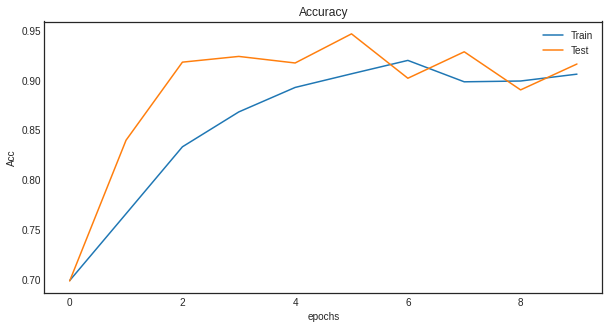

In [35]:
plt.figure()
plt.plot(history.history["accuracy"], label = "Train")
plt.plot(history.history["val_accuracy"], label = "Test")
plt.title("Accuracy")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

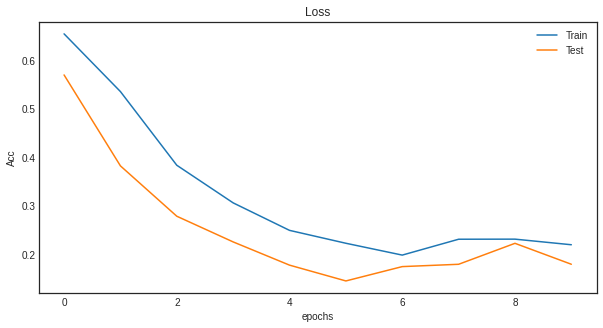

In [36]:
plt.figure()
plt.plot(history.history["loss"], label = "Train")
plt.plot(history.history["val_loss"], label = "Test")
plt.title("Loss")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

In [41]:
pred = model1.predict(X_test)
p_pred = pred.flatten()
print(p_pred.round(2))
# [1. 0.01 0.91 0.87 0.06 0.95 0.24 0.58 0.78 ...

# extract the predicted class labels
y_pred = np.where(p_pred > 0.5, 1, 0)
print(y_pred)

[0.   0.88 0.93 ... 0.87 0.94 0.  ]
[0 1 1 ... 1 1 0]


In [42]:
# Creating classification report 
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.84      0.91      4317
           1       0.87      0.99      0.93      4659

    accuracy                           0.92      8976
   macro avg       0.93      0.92      0.92      8976
weighted avg       0.93      0.92      0.92      8976



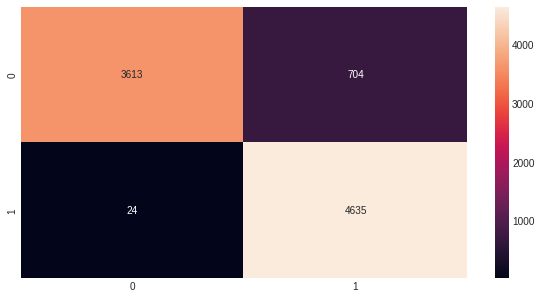

In [43]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
# cm = metrics.confusion_matrix(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)
f = sns.heatmap(cm, annot=True, fmt='d')

In [44]:
!mkdir -p saved_model
model1.save('saved_model/lstmModel')

INFO:tensorflow:Assets written to: saved_model/lstmModel/assets


INFO:tensorflow:Assets written to: saved_model/lstmModel/assets


In [ ]:
new_model = tf.keras.models.load_model('saved_model/lstmModel')